# Quest2Dx Demo Notebook for Inference

This notebook demonstrates how to use Quest2Dx for inference. Quest2Dx takes questions and answers from health questionnaires and predicts if the subject has Parkinson's disease or not. The model demonstrated in this notebook is trained on the Parkinson's Progression Markers Initiative (PPMI) dataset. This demo notebook uses to sample subjects from the PPMI dataset to demonstrate the inference process, one with Parkinson's disease and one without.

The notebook is organized as follows:
1. Load libraries and set up basic configurations
2. Load the data
3. Load the model
4. Run inference
5. Diagnosis Prediction and Relevant Questions Visualization

#### 1a. Load libraries

In [16]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
from tokenization_exp.ft_transformer_wPosEnc import FTTransformer
from released.utils import select_gpu
import matplotlib.pyplot as plt
import seaborn as sns
from released.utils import darken_color
import textwrap

#### 1b. Set basic configurations

In [17]:
# Set data paths
sample_path = '/home/machad/fast/pd_subtype/demo_sample_data.pkl'
model_checkpoint = '/home/machad/fast/pd_subtype/results_new/cross-dataset_new_fox2ppmi_0.5/checkpoints/Tabular_token_explore_debug.pt'
config_path = '/home/machad/fast/pd_subtype/demo_config.pkl'
question_mapping_dict_path = '/home/machad/fast/pd_subtype/question_mapping.pkl'

In [18]:
# Load model configuration
with open(config_path, 'rb') as f:
    config = pickle.load(f)

# Load question mapping dictionary for plotting
with open(question_mapping_dict_path, 'rb') as f:
    question_mapping_dict = pickle.load(f)

# GPU settings
gpu_id = None
if gpu_id is None:
    print('No GPU number given, selecting GPU with least memory usage.')
    gpu_id = ','.join(select_gpu(1,verbose=True))
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

# If no GPU is available, use CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
config['device'] = device

No GPU number given, selecting GPU with least memory usage.
GPU 2: Memory Usage 2 MB
GPU 3: Memory Usage 2 MB
GPU 5: Memory Usage 2 MB
GPU 6: Memory Usage 2 MB
GPU 4: Memory Usage 1470 MB
GPU 7: Memory Usage 1470 MB
GPU 0: Memory Usage 3102 MB
GPU 1: Memory Usage 5720 MB


#### 2. Load data

In [19]:
# Load data
sample = pickle.load(open(sample_path, 'rb'))

# Prepare Quest2Dx inputs and target
cat_vars = sample['ppmi_cat_emb']
cont_vars = sample['ppmi_og_num']
target = sample['target_ppmi']

#### 3. Load model

In [20]:
# Create model
model = FTTransformer(
    categories = config['num_categories'],
    num_continuous = config['num_cont'], 
    dim = config['d_model'],            
    dim_out = 2,                        
    depth = config['num_layers'],       
    heads = config['nhead'],            
    attn_dropout = config['dropout'],   
    ff_dropout =  config['dropout'],     
    path_col_name_emb = config['path_col_name_emb'],
    missing_method = config['missing_method'],
    columns_to_drop = None,
    subset_col_idx = config['subset_col_idx'],
)

# Load model checkpoint
model_state, _ = torch.load(model_checkpoint)
model.load_state_dict(model_state)
model = model.to(device)

#### 4. Run inference

In [21]:
target = torch.tensor(target)
cont_vars = torch.tensor(cont_vars.values)
model.eval()
with torch.no_grad():
    target, cont_vars, cat_vars = target.to(device).long(), cont_vars.to(device).float(), cat_vars.to(device).long() 
    severity_score, attn_weights = model(cat_vars,cont_vars)
    severity_score, attn_weights = severity_score.cpu(), attn_weights.cpu().numpy()

In [22]:
# Calculate softmax of severity score to get prediction probabilities
severity_score = torch.nn.functional.softmax(severity_score, dim=1)
# Get the predicted class
predicted_dx = torch.argmax(severity_score, dim=1)

#### 5. Diagnosis Prediction and Relevant Questions Visualization

In [23]:
# Recode the predicted class to the original diagnosis (0 = Non-PD, 1 = Parkinson's Disease)
predicted_dx = np.where(predicted_dx == 0, 'Non-Parkinson\'s Disease', 'Parkinson\'s Disease')

print(f'Predicted diagnosis for participant 1: {predicted_dx[0]}')
print(f'Predicted diagnosis for participant 1: {predicted_dx[1]}')

Predicted diagnosis for participant 1: Non-Parkinson's Disease
Predicted diagnosis for participant 1: Parkinson's Disease


In [24]:
# Get the top 5 most important features
attn_weights = attn_weights.reshape(-1)
top_5_idx = np.argsort(attn_weights)[-5:]
top_5_features = [question_mapping_dict.get(idx) for idx in top_5_idx]
top_5_weights = attn_weights[top_5_idx]

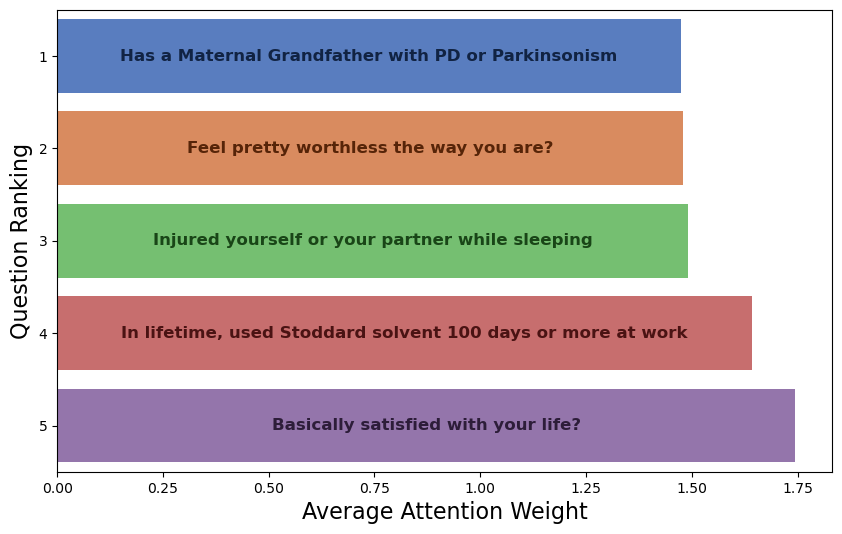

In [27]:
# Prepare the data for plotting
plot_data = pd.DataFrame({'Feature': top_5_features, 'Attention Weight': top_5_weights, 'Index': range(1,6)})

# Plot settings
plt.figure(figsize=(10, 6)) 
# Create the warm palette with the same number of colors as bars
palette = sns.color_palette("muted", n_colors=len(top_5_features))
# Create the horizontal bar plot with seaborn
bar_plot = sns.barplot(data=plot_data, y='Index', x='Attention Weight',
                       palette=palette, orient='h', width=0.8)

# Add feature names inside bars
for i, bar in enumerate(bar_plot.patches):
    bar_width = bar.get_width()
    feature_name = plot_data['Feature'].iloc[i]
    
    # Dynamically calculate wrap width based on bar width, with a minimum width threshold
    wrap_width = max(int(bar_width * 80), 80)
    wrapped_text = textwrap.fill(feature_name, width=wrap_width)  # Adjust width dynamically

    # Darken the bar color for the text
    bar_color = palette[i]
    darker_color = darken_color(bar_color, amount=0.3)
    
    # Display the questions inside the bars
    plt.text(bar_width * 0.5, bar.get_y() + bar.get_height() / 2, wrapped_text,
             ha='center', va='center', rotation='horizontal', color=darker_color,  
             fontweight='bold', fontsize=12)

plt.ylabel('Question Ranking', fontsize=16)
plt.xlabel('Average Attention Weight', fontsize=16)
plt.show()